## 8.7. 通过时间反向传播 
它要求我们将循环神经网络的计算图一次展开一个时间步， 以获得模型变量和参数之间的依赖关系。 然后，基于链式法则，应用反向传播来计算和存储梯度。 由于序列可能相当长，因此依赖关系也可能相当长。 

### 8.7.1. 循环神经网络的梯度分析
我们将时间步 $t$ 的隐状态表示为 $h_t$ ， 输入表示为 $x_t$ ，输出表示为 $o_t$ 。分别使用 $w_h$ 和 $w_o$ 来表示隐藏层和输出层的权重。 每个时间步的隐状态和输出可以写为:
$$
\begin{split}\begin{aligned}h_t &= f(x_t, h_{t-1}, w_h),\\o_t &= g(h_t, w_o),\end{aligned}\end{split}
$$
前向传播是通过一次一个 $t$ 遍历三元组 $(x_t, h_t, o_t)$, 再通过 $L$ 函数评估差异:
$$
L(x_1, \dots, x_T, y_1, \dots, y_T, w_h, w_o) = \sum_{t=1}^T l(y_t, o_t)
$$
对于反向传播, 我们需要计算 $L$ 关于 $w_h$ 和 $w_o$ 的梯度。 由于 $L$ 是一个标量, 我们可以使用链式法则来计算:
$$
\begin{split}\begin{aligned}\frac{\partial L}{\partial w_h} &= \sum_{t=1}^T \frac{\partial L}{\partial o_t} \frac{\partial o_t}{\partial h_t} \frac{\partial h_t}{\partial w_h},\\\frac{\partial L}{\partial w_o} &= \sum_{t=1}^T \frac{\partial L}{\partial o_t} \frac{\partial o_t}{\partial w_o}.\end{aligned}\end{split}
$$
$\partial h_t/\partial w_h$ 链:
$$
\frac{\partial h_t}{\partial w_h}=\frac{\partial f(x_{t},h_{t-1},w_h)}{\partial w_h}+\sum_{i=1}^{t-1}\left(\prod_{j=i+1}^{t} \frac{\partial f(x_{j},h_{j-1},w_h)}{\partial h_{j-1}} \right) \frac{\partial f(x_{i},h_{i-1},w_h)}{\partial w_h}.
$$
当我们计算目标函数 $L$ 关于参数 $w_h$ 的梯度时, 当 $t$ 很大时 $\partial h_t/\partial w_h$ 这一项会变得很长, 我们需要想想办法来处理这一问题.

#### 8.7.1.1 比较策略
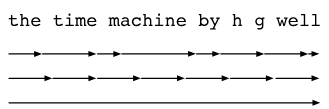
- 第一行采用随机截断，方法是将文本划分为不同长度的片断；
- 第二行采用常规截断，方法是将文本分解为相同长度的子序列。 这也是我们在循环神经网络实验中一直在做的；
- 第三行采用通过时间的完全反向传播，结果是产生了在计算上不可行的表达式。
遗憾的是，虽然随机截断在理论上具有吸引力， 但很可能是由于多种因素在实践中并不比常规截断更好。 首先，在对过去若干个时间步经过反向传播后， 观测结果足以捕获实际的依赖关系。 其次，增加的方差抵消了时间步数越多梯度越精确的事实。 第三，我们真正想要的是只有短范围交互的模型。 因此，模型需要的正是截断的通过时间反向传播方法所具备的轻度正则化效果。

### 8.7.2. 通过时间反向传播的细节
为了保持简单，我们考虑一个没有偏置参数的循环神经网络， 其在隐藏层中的激活函数使用恒等映射（ $\phi(x) = x$ ）。 对于时间步 $t$ ，设单个样本的输入及其对应的标签分别为 $\mathbf{x}_t \in \mathbb{R}^d$ 和 $y_t$ 。 计算隐状态 $\mathbf{h}_t \in \mathbb{R}^h$ 和输出 $\mathbf{o}_t \in \mathbb{R}^q$ 的方式为：
$$
\begin{split}\begin{aligned}\mathbf{h}_t &= \mathbf{W}_{hx} \mathbf{x}_t + \mathbf{W}_{hh} \mathbf{h}_{t-1},\\
\mathbf{o}_t &= \mathbf{W}_{qh} \mathbf{h}_{t},\end{aligned}\end{split}
$$
下图表示具有三个时间步的循环神经网络模型依赖关系的计算图。未着色的方框表示变量，着色的方框表示参数，圆表示运算符  
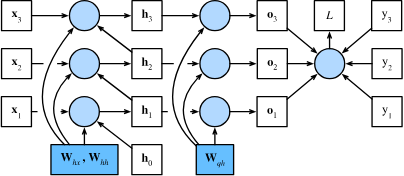  
在任意时间步 $t$ ， 目标函数关于模型输出的微分:  
$$
\frac{\partial L}{\partial \mathbf{o}_t} =  \frac{\partial l (\mathbf{o}_t, y_t)}{T \cdot \partial \mathbf{o}_t} \in \mathbb{R}^q.
$$
目标函数关于输出层中参数 $\mathbf{W}_{qh}$ 的梯度, 使用链式法则:  
$$
\frac{\partial L}{\partial \mathbf{W}_{qh}}
= \sum_{t=1}^T \text{prod}\left(\frac{\partial L}{\partial \mathbf{o}_t}, \frac{\partial \mathbf{o}_t}{\partial \mathbf{W}_{qh}}\right)
= \sum_{t=1}^T \frac{\partial L}{\partial \mathbf{o}_t} \mathbf{h}_t^\top,
$$
在最后的时间步 $T$ ，目标函数 $L$ 仅通过 $o_T$ 依赖于隐状态 $h_T$　。 因此，我们通过使用链式法可以很容易地得到梯度 $\partial L/\partial \mathbf{h}_T \in \mathbb{R}^h$
：
$$
\frac{\partial L}{\partial \mathbf{h}_T} = \text{prod}\left(\frac{\partial L}{\partial \mathbf{o}_T}, \frac{\partial \mathbf{o}_T}{\partial \mathbf{h}_T} \right) = \mathbf{W}_{qh}^\top \frac{\partial L}{\partial \mathbf{o}_T}.
$$
根据链式法则，隐状态的梯度在任何时间步骤 $t < T$ 时都可以递归地计算为：
$$
\frac{\partial L}{\partial \mathbf{h}_t} = \text{prod}\left(\frac{\partial L}{\partial \mathbf{h}_{t+1}}, \frac{\partial \mathbf{h}_{t+1}}{\partial \mathbf{h}_t} \right) + \text{prod}\left(\frac{\partial L}{\partial \mathbf{o}_t}, \frac{\partial \mathbf{o}_t}{\partial \mathbf{h}_t} \right) = \mathbf{W}_{hh}^\top \frac{\partial L}{\partial \mathbf{h}_{t+1}} + \mathbf{W}_{qh}^\top \frac{\partial L}{\partial \mathbf{o}_t}.
$$
对于任何时间步 $1 \leq t \leq T$ 展开递归计算得：
$$
\frac{\partial L}{\partial \mathbf{h}_t}= \sum_{i=t}^T {\left(\mathbf{W}_{hh}^\top\right)}^{T-i} \mathbf{W}_{qh}^\top \frac{\partial L}{\partial \mathbf{o}_{T+t-i}}.
$$
这个简单的线性例子已经展现了长序列模型的一些关键问题： 它陷入到 $\mathbf{W}_{hh}^\top$ 的潜在的非常大的幂。 在这个幂中，小于1的特征值将会消失，大于1的特征值将会发散。 这在数值上是不稳定的，表现形式为梯度消失或梯度爆炸。 
最后,计算有关 $\mathbf{W}_{hx}, \mathbf{W}_{hh}$ 这些参数的梯度 $\partial L / \partial \mathbf{W}_{hx} \in \mathbb{R}^{h \times d}$ 和 $\partial L / \partial \mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$ ， 我们应用链式规则得：
$$
\begin{split}\begin{aligned}
\frac{\partial L}{\partial \mathbf{W}_{hx}}
&= \sum_{t=1}^T \text{prod}\left(\frac{\partial L}{\partial \mathbf{h}_t}, \frac{\partial \mathbf{h}_t}{\partial \mathbf{W}_{hx}}\right)
= \sum_{t=1}^T \frac{\partial L}{\partial \mathbf{h}_t} \mathbf{x}_t^\top,\\
\frac{\partial L}{\partial \mathbf{W}_{hh}}
&= \sum_{t=1}^T \text{prod}\left(\frac{\partial L}{\partial \mathbf{h}_t}, \frac{\partial \mathbf{h}_t}{\partial \mathbf{W}_{hh}}\right)
= \sum_{t=1}^T \frac{\partial L}{\partial \mathbf{h}_t} \mathbf{h}_{t-1}^\top,
\end{aligned}\end{split}
$$

由于通过时间反向传播是反向传播在循环神经网络中的应用方式， 所以训练循环神经网络交替使用前向传播和通过时间反向传播。 
具体而言，存储的中间值会被重复使用，以避免重复计算， 例如存储 $\partial L/\partial \mathbf{h}_t$ ， 以便在计算 $\partial L / \partial \mathbf{W}_{hx}$ 和 $\partial L / \partial \mathbf{W}_{hh}$ 时使用。

### 8.7.4. 练习解答

1. **假设我们拥有一个对称矩阵 $M \in \mathbb{R}^{n \times n}$，其特征值为 $\lambda_i$，对应的特征向量是 $v_i$ $(i=1,\dots,n)$。通常情况下，假设特征值的序列顺序为 $|\lambda_i| \geq |\lambda_{i+1}|$。**

    1. **证明 $M^k$ 拥有特征值 $\lambda_i^k$。**

        对于对称矩阵 $M$，其特征分解为 $M = V \Lambda V^\top$，其中 $V$ 是特征向量组成的正交矩阵，$\Lambda$ 是对角矩阵，包含特征值 $\lambda_i$。  
        则 $M^k = (V \Lambda V^\top)^k = V \Lambda^k V^\top$，其中 $\Lambda^k$ 是对角矩阵，其对角线元素为 $\lambda_i^k$。  
        因此，$M^k$ 的特征值为 $\lambda_i^k$。

    2. **证明对于一个随机向量 $x \in \mathbb{R}^n$，$M^k x$ 将有较高概率与 $M$ 的特征向量 $v_1$ 在一条直线上。形式化这个证明过程。**

        假设随机向量 $x$ 可以表示为特征向量的线性组合：$x = \sum_{i=1}^n c_i v_i$，其中 $c_i$ 是系数。  
        则 $M^k x = M^k \left(\sum_{i=1}^n c_i v_i\right) = \sum_{i=1}^n c_i M^k v_i = \sum_{i=1}^n c_i \lambda_i^k v_i$。  
        当 $k$ 很大时，由于 $|\lambda_1| \geq |\lambda_2| \geq \dots \geq |\lambda_n|$，$\lambda_1^k$ 将主导其他项，因此 $M^k x \approx c_1 \lambda_1^k v_1$。  
        这表明 $M^k x$ 与 $v_1$ 在一条直线上。

    3. **上述结果对于循环神经网络中的梯度意味着什么？**

        在循环神经网络中，梯度的传播类似于矩阵幂的计算。如果矩阵的最大特征值大于 1，则梯度会爆炸；如果小于 1，则梯度会消失。这解释了梯度消失和梯度爆炸问题的来源。

2. **除了梯度截断，还有其他方法来应对循环神经网络中的梯度爆炸吗？**

    - 使用梯度裁剪（Gradient Clipping）：将梯度的范数限制在某个阈值范围内。
    - 使用正则化方法：例如权重正则化（L2 正则化）来限制权重的大小。
    - 使用改进的优化算法：如 RMSProp、Adam 等，它们可以动态调整学习率。
    - 使用更好的循环神经网络结构：如 LSTM 或 GRU，它们通过门控机制缓解了梯度消失和爆炸问题。
    - 初始化权重时使用更好的策略：如 Xavier 初始化或 He 初始化，确保初始权重的分布适当。
    - 使用归一化技术：如批量归一化（Batch Normalization）或层归一化（Layer Normalization）来稳定训练过程。
